In [7]:
'''pip install nbimporter
'''

'pip install nbimporter\n'

In [8]:
import nbimporter

#==============================Dependencies================================

#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time

#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [9]:
from hybrid_mcmc_KDE import metropolis_python, silverman_bandwidth, adaptive_kde, hybrid_importance_sampling  

from Importance_Int import importance_integration, target_pdf

from Uniform_MC import uniform_mc_integrate

In [10]:
def f(x):
    return 1 / (1 + x**2)  # Cauchy distribution

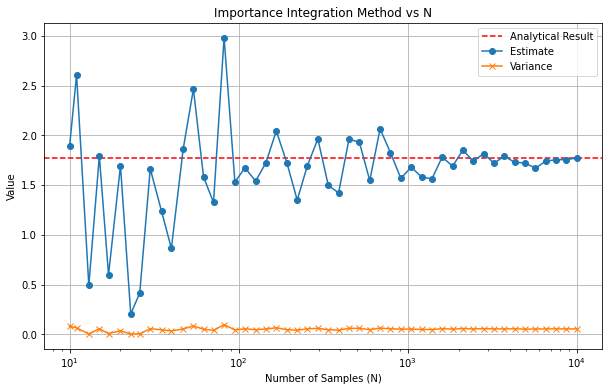

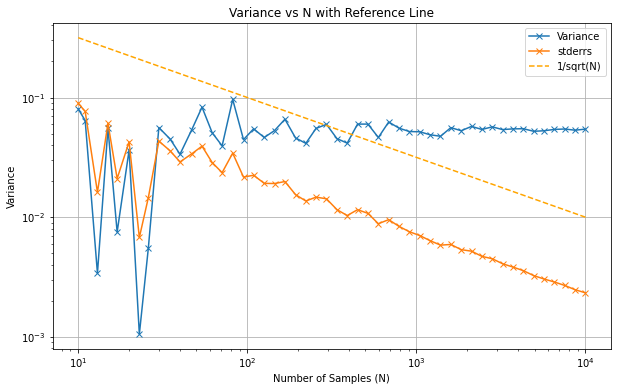

In [11]:
# Define the function f(x) = e^(-x^2)
def f(x):
    return np.exp(-x**2)

a = -10
b = 10


# Define a range of N values
N_values = np.logspace(1, 4, num=50, dtype=int)  # N ranges from 10 to 10,000

# Initialize lists to store results
estimates = []
variances = []
stderrs = []

# Compute the importance integration for each N
for N in N_values:
    estimate, variance, stderr = uniform_mc_integrate(f, a, b, N, rng)
    estimates.append(estimate)
    variances.append(variance)
    stderrs.append(stderr)

# Plot the results
plt.figure(figsize=(10, 6))
# Analytical result for the integral of f(x) = e^(-x^2) over the real line
analytical_result = np.sqrt(np.pi)

# Add the analytical result as a horizontal line
plt.axhline(y=analytical_result, color='red', linestyle='--', label='Analytical Result')
plt.plot(N_values, estimates, label='Estimate', marker='o')
plt.plot(N_values, variances, label='Variance', marker='x')
plt.xscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Value')
plt.title('Importance Integration Method vs N')
plt.legend()
plt.grid(True)
plt.show()

# Compute the reference line 1/sqrt(N_values)
reference_line = 1 / np.sqrt(N_values)

# Plot the variance and reference line
plt.figure(figsize=(10, 6))
plt.plot(N_values, variances, label='Variance', marker='x')
plt.plot(N_values, stderrs, label='stderrs', marker='x')

plt.plot(N_values, reference_line, label='1/sqrt(N)', linestyle='--', color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Variance')
plt.title('Variance vs N with Reference Line')
plt.legend()
plt.grid(True)
plt.show()

Acceptance rate: 0.23
Acceptance rate: 0.21
Acceptance rate: 0.26
Acceptance rate: 0.17
Acceptance rate: 0.18
Acceptance rate: 0.22
Acceptance rate: 0.23
Acceptance rate: 0.29
Acceptance rate: 0.22
Acceptance rate: 0.22
Acceptance rate: 0.25
Acceptance rate: 0.19
Acceptance rate: 0.22
Acceptance rate: 0.20
Acceptance rate: 0.21
Acceptance rate: 0.25
Acceptance rate: 0.18
Acceptance rate: 0.17
Acceptance rate: 0.20
Acceptance rate: 0.20
Acceptance rate: 0.19
Acceptance rate: 0.21
Acceptance rate: 0.20
Acceptance rate: 0.19
Acceptance rate: 0.24
Acceptance rate: 0.21
Acceptance rate: 0.21
Acceptance rate: 0.23
Acceptance rate: 0.20
Acceptance rate: 0.22
Acceptance rate: 0.23
Acceptance rate: 0.21
Acceptance rate: 0.25
Acceptance rate: 0.20
Acceptance rate: 0.22
Acceptance rate: 0.20
Acceptance rate: 0.22
Acceptance rate: 0.22
Acceptance rate: 0.21
Acceptance rate: 0.22
Acceptance rate: 0.22
Acceptance rate: 0.21
Acceptance rate: 0.22
Acceptance rate: 0.22
Acceptance rate: 0.23
Acceptance

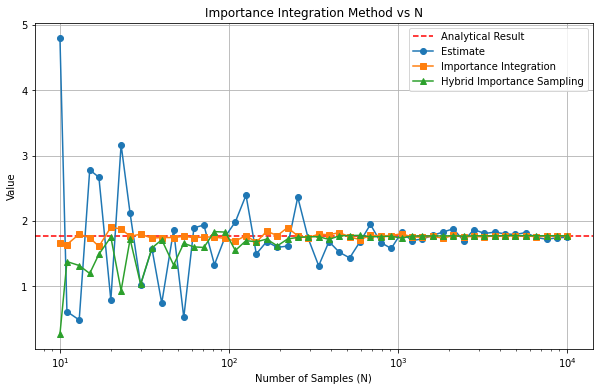

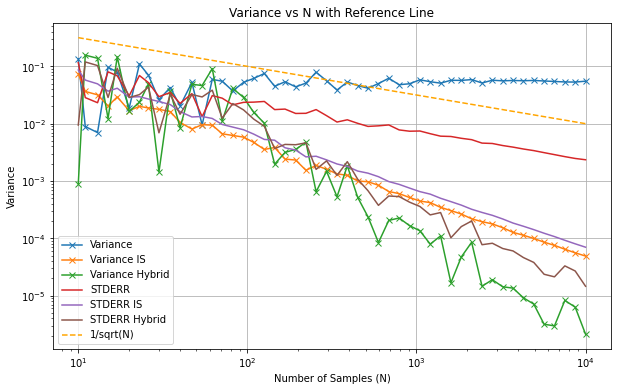

In [12]:
# Define the function f(x) = e^(-x^2)
def f(x):
    return np.exp(-x**2)

a=-10
b=10



# Define a range of N values
N_values = np.logspace(1, 4, num=50, dtype=int)  # N ranges from 10 to 10,000

# Initialize lists to store results
estimates_u = []
variances_u = []
standard_errors_u = []

estimates_i = []
variances_i = []
standard_errors_i = []

estimates_h = []
variances_h = []
standard_errors_h = []

# Compute the importance integration for each N
for N in N_values:
    # Uniform Monte Carlo integration
    estimate_u, variance_u, standard_error_u = uniform_mc_integrate(f, a, b, N, rng) #standard_error_u
    estimates_u.append(estimate_u)
    variances_u.append(variance_u)
    standard_errors_u.append(standard_error_u)

    #Importance sampling integration
    estimate_i, variance_i, standard_error_i = importance_integration(f, N, rng)
    estimates_i.append(estimate_i)
    variances_i.append(variance_i)
    standard_errors_i.append(standard_error_i)

    # Hybrid importance sampling integration
    m_chain = metropolis_python(f, N, rng.uniform(-1, 1), 4, 200, 1)
    h_fixed = silverman_bandwidth(m_chain)
    kde = adaptive_kde(m_chain, h_fixed, alpha=0.5)

    estimate_h, variance_h, standard_error_h = hybrid_importance_sampling(f, m_chain, kde)
    estimates_h.append(estimate_h)
    variances_h.append(variance_h)
    standard_errors_h.append(standard_error_h)





# Plot the results
plt.figure(figsize=(10, 6))
# Analytical result for the integral of f(x) = e^(-x^2) over the real line
analytical_result = np.sqrt(np.pi)

# Add the analytical result as a horizontal line
plt.axhline(y=analytical_result, color='red', linestyle='--', label='Analytical Result')
plt.plot(N_values, estimates_u, label='Estimate', marker='o')
plt.plot(N_values, estimates_i, label='Importance Integration', marker='s')
plt.plot(N_values, estimates_h, label='Hybrid Importance Sampling', marker='^')
plt.xscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Value')
plt.title('Importance Integration Method vs N')
plt.legend()
plt.grid(True)
plt.show()

# Compute the reference line 1/sqrt(N_values)
reference_line = 1 / np.sqrt(N_values)

# Plot the variance and reference line
plt.figure(figsize=(10, 6))
plt.plot(N_values, variances_u, label='Variance', marker='x')
plt.plot(N_values, variances_i, label='Variance IS', marker='x')
plt.plot(N_values, variances_h, label='Variance Hybrid', marker='x')
plt.plot(N_values, standard_errors_u, label='STDERR')
plt.plot(N_values, standard_errors_i, label='STDERR IS')
plt.plot(N_values, standard_errors_h, label='STDERR Hybrid')
plt.plot(N_values, reference_line, label='1/sqrt(N)', linestyle='--', color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Variance')
plt.title('Variance vs N with Reference Line')
plt.legend()
plt.grid(True)
plt.show()